In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tarfile
import scipy.io as sio
import numpy as np
import os
import cv2 as cv
import shutil
import random
from pathlib import Path
import pandas as pd

In [14]:
pwd

'C:\\Users\\Morningstar\\Documents\\CARSv2'

In [2]:
from utils import get_path, get_x, get_y, show_img, draw_outline, draw_rect, draw_text, crop, compare_top_losses, compare_most_confused

In [3]:
path = get_path();path

WindowsPath('C:/Users/Morningstar/Documents/CARSv2')

In [5]:
list(path.iterdir())

[WindowsPath('C:/Users/Morningstar/Documents/CARSv2/.ipynb_checkpoints'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/1-CarsBaseline.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/2-CarsBaseline-ImgScaling.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/3-Cars-ImgScaling-LrRatesTuning.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasic.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasicv2-BasicResNet50.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasicv2-TRES.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasicv2.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_annos.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_meta.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_test_annos.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_test_annos_withlabels.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_trai

In [4]:
cars_test = Path(path/'test')
cars_train = Path(path/'train')

In [6]:
len(list(cars_test.iterdir()))
len(list(cars_train.iterdir()))

8144

# Ucitavanje i kreiranje DataBlock i DataLoaders objekta

In [4]:
from fastai.vision.all import *
from fastai.metrics import error_rate
from fastai import *
import cv2 as cv
import numpy as np
import pandas as pd
import scipy.io as sio
from PIL import Image
import timm
from wwf.vision.timm import *
import torch
import torchvision
import random
from torch.distributions.beta import Beta

In [5]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

Ucitavanje pandas dataframe-ova

In [6]:
labels_df = pd.read_csv(path/'labels_with_annos.csv')
train_labels_df = pd.read_csv(path/'train_labels_with_annos.csv')
test_labels_df = pd.read_csv(path/'test_labels_with_annos.csv')

In [11]:
labels_df.head(10)

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,class_name,is_test,filename_cropped,bbox_h,bbox_w
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,0,cropped_00001.jpg,260,531
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,0,cropped_00002.jpg,472,833
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,0,cropped_00003.jpg,273,517
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,0,cropped_00004.jpg,704,864
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,0,cropped_00005.jpg,64,120
5,00006.jpg,259,289,515,416,123,Geo Metro Convertible 1993,0,cropped_00006.jpg,128,257
6,00007.jpg,88,80,541,397,89,Dodge Journey SUV 2012,0,cropped_00007.jpg,318,454
7,00008.jpg,73,79,591,410,96,Dodge Charger Sedan 2012,0,cropped_00008.jpg,332,519
8,00009.jpg,20,126,1269,771,167,Mitsubishi Lancer Sedan 2012,0,cropped_00009.jpg,646,1250
9,00010.jpg,21,110,623,367,58,Chevrolet Traverse SUV 2012,0,cropped_00010.jpg,258,603


In [12]:
train_labels_df.head(10)

,filename,class_name,class_id
0,00001.jpg,Audi TTS Coupe 2012,14
1,00002.jpg,Acura TL Sedan 2012,3
2,00003.jpg,Dodge Dakota Club Cab 2007,91
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,134
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,106
5,00006.jpg,Geo Metro Convertible 1993,123
6,00007.jpg,Dodge Journey SUV 2012,89
7,00008.jpg,Dodge Charger Sedan 2012,96
8,00009.jpg,Mitsubishi Lancer Sedan 2012,167
9,00010.jpg,Chevrolet Traverse SUV 2012,58


In [13]:
test_labels_df.head(10)

,filename,class_name,class_id,vocab_id
0,test_00001.jpg,Suzuki Aerio Sedan 2007,181,180
1,test_00002.jpg,Ferrari 458 Italia Convertible 2012,103,100
2,test_00003.jpg,Jeep Patriot SUV 2012,145,147
3,test_00004.jpg,Toyota Camry Sedan 2012,187,186
4,test_00005.jpg,Tesla Model S Sedan 2012,185,184
5,test_00006.jpg,Chrysler Town and Country Minivan 2012,78,80
6,test_00007.jpg,GMC Terrain SUV 2012,118,120
7,test_00008.jpg,Mercedes-Benz S-Class Sedan 2012,165,163
8,test_00009.jpg,BMW X5 SUV 2007,32,35
9,test_00010.jpg,Chevrolet HHR SS 2010,60,61


Funkcija za dobavljanje dataloaders objekta na osnovu velicine slike, batch size i seed parametra. 

In [7]:
def get_dls(size,bs,seed):
    random_seed(seed,True)
    augs = [*aug_transforms(size=size),Normalize.from_stats(*imagenet_stats),ToTensor()]
    
    dblock= DataBlock((ImageBlock, CategoryBlock),
                  splitter=RandomSplitter(seed=seed),
                  get_x=get_x, 
                  get_y=get_y,
                  item_tfms=[Resize(480, method='squish'),ToTensor()],
                  batch_tfms=augs)
    dls = dblock.dataloaders(train_labels_df, bs=bs, num_workers=0)
    return dls

# Label smoothing + MixUp + Img Scaling + Ranger

U ovoj varijanti cemo kombinirati label smoothing loss funkciju sa MixUp regularizacijom i velikim brojem trening epoha da bi ove dvije metode imali sto bolji efekat. Također koristit cemo Ranger optimizator (RAdam + Lookahead) i Mish aktivacijsku funkciju umjesto ReLU. Nacin treniranja je flat cosine annealing metoda.

In [8]:
device = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")

In [9]:
#Ranger optimizer
def opt_func(ps, lr=defaults.lr): return Lookahead(RAdam(ps, lr=lr))

In [10]:
def convert_act_cls(model, layer_type_old, layer_type_new):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_act_cls(module, layer_type_old, layer_type_new)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = layer_type_new
            model._modules[name] = layer_new

    return model

## Size 192 Stage1

In [11]:
size = 192
bs = 64
seed = 42
dls = get_dls(size, bs, seed)

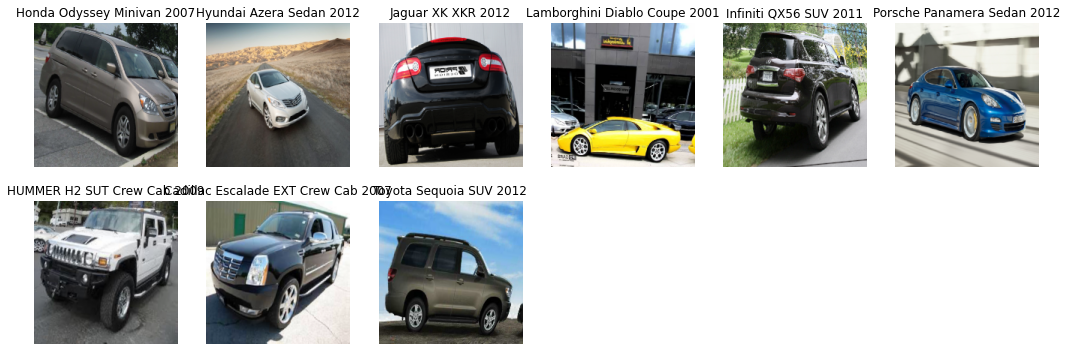

In [12]:
dls.show_batch(nrows=2, ncols=6)

## Kreiranje modela

Kreiramo model koristeci gluon seresnext50 arhitekturu, što je unaprijeđena verzija resnet50 arhitekture, sa Label Smoothing loss funkcijom i Mixup regularizacijom.
Kao optimizator se koristi Ranger, a aktivacijska funkcija će biti zamijenjena iz ReLU u Mish.

Kao metrika po kojoj cemo pratiti trening koristimo preciznost(accuracy).

Dio to_fp16() definira mixed precision trening koji ubrzava trening na određenim grafickim karticama kao sto je moja RTX 2060 Super.

In [12]:
learn = timm_learner(dls,'gluon_seresnext50_32x4d', loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy], opt_func=opt_func, cbs=MixUp).to_fp16()

In [13]:
learn.model = convert_act_cls(learn.model,nn.ReLU, Mish())

In [19]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 192 x 192'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 40 x 96 x 96    1,080      False     
________________________________________________________________
BatchNorm2d          64 x 40 x 96 x 96    80         True      
________________________________________________________________
SwishMe              64 x 40 x 96 x 96    0          False     
________________________________________________________________
Conv2d               64 x 40 x 96 x 96    360        False     
________________________________________________________________
BatchNorm2d          64 x 40 x 96 x 96    80         True      
________________________________________________________________
SwishMe              64 x 40 x 96 x 96    0          False     
________________________________________________________________
AdaptiveAvgPool2d    64 x 40 x 1 x 1      0          False     
_________________________________________________

Nakon kreiranja modela mozemo krenuti sa treningom.

## Treniranje modela

In [15]:
random_seed(42, True)
learn.lr_find()

KeyboardInterrupt: 

In [30]:
random_seed(42,True)
learn.fit_flat_cos(40,lr=3e-2, pct_start=0.30)

epoch,train_loss,valid_loss,accuracy,time
0,6.308739,4.690061,0.106265,04:22
1,5.016765,3.640232,0.241400,04:28
2,4.304764,3.150379,0.374079,04:23
3,3.890182,2.715594,0.492015,04:18
4,3.657845,2.488952,0.556511,04:17
5,3.730479,2.411087,0.589681,04:18
6,3.447112,2.590076,0.541769,04:18
7,3.328563,2.411806,0.566953,04:17
8,3.284754,2.159853,0.659091,04:17
9,3.215725,2.100435,0.673833,04:17


In [16]:
learn.save('stage1-seresnet50-mixuplabelsmooth-imgscale-192px')

Path('models/stage1-seresnet50-mixuplabelsmooth-imgscale-192px.pth')

In [14]:
learn.load('stage1-seresnet50-mixuplabelsmooth-imgscale-192px')

## Stage 2 size 256

In [15]:
size = 256
bs = 32
seed = 42
dls = get_dls(size, bs, seed)

In [16]:
learn.dls = dls

SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=9.999999747378752e-06)

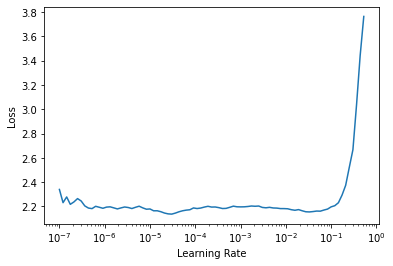

In [18]:
random_seed(42,True)
learn.lr_find()

In [19]:
random_seed(42,True)
learn.fine_tune(15, freeze_epochs=3, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.173306,1.584283,0.836609,06:13
1,2.133594,1.551526,0.839066,05:53
2,2.164902,1.536290,0.842752,05:52


epoch,train_loss,valid_loss,accuracy,time
0,2.150605,1.529383,0.841523,06:44
1,2.136555,1.516510,0.846437,07:04
2,2.084495,1.502754,0.850123,07:02
3,2.084503,1.487082,0.856265,06:12
4,2.071475,1.479091,0.856265,06:24
5,2.051970,1.477562,0.861794,06:57
6,2.067218,1.473171,0.856265,06:53
7,2.061285,1.476974,0.858722,06:53
8,2.035972,1.463819,0.858722,06:54
9,2.041044,1.466084,0.864865,06:51


In [20]:
learn.save('stage2-seresnet50-mixuplabelsmooth-imgscale-256px')

Path('models/stage2-seresnet50-mixuplabelsmooth-imgscale-256px.pth')

In [17]:
learn.load('stage2-seresnet50-mixuplabelsmooth-imgscale-256px')

## Stage 3 Size 299

In [18]:
size = 299
bs = 24
seed = 42
dls = get_dls(size, bs, seed)

In [19]:
learn.dls = dls

In [19]:
learn.lr_find()

RuntimeError: The size of tensor a (64) must match the size of tensor b (7) at non-singleton dimension 3

In [25]:
random_seed(42,True)
learn.fit_flat_cos(40,lr=3e-5, pct_start=0.30)

epoch,train_loss,valid_loss,accuracy,time
0,2.081638,1.447600,0.866093,08:01
1,2.038722,1.435894,0.871622,07:46
2,2.032171,1.424638,0.872236,07:39
3,2.020743,1.419391,0.875307,07:39
4,2.054134,1.419939,0.871007,07:56
5,2.028405,1.409498,0.878378,08:15
6,2.023616,1.405643,0.880221,08:15
7,2.001745,1.400378,0.886364,08:08
8,1.955028,1.403912,0.875921,08:12
9,1.998766,1.384519,0.886364,08:13


In [26]:
learn.save('stage3-seresnet50-mixuplabelsmooth-imgscale-299px')

Path('models/stage3-seresnet50-mixuplabelsmooth-imgscale-299px.pth')

In [20]:
learn.load('stage3-seresnet50-mixuplabelsmooth-imgscale-299px')

In [27]:
learn.lr_find()

RuntimeError: The size of tensor a (64) must match the size of tensor b (7) at non-singleton dimension 3

In [27]:
random_seed(42,True)
learn.fine_tune(15, freeze_epochs=3, max_lr=1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,1.853971,1.361377,0.893735,07:16
1,1.842902,1.358785,0.892506,07:36
2,1.851547,1.367482,0.891892,08:01


epoch,train_loss,valid_loss,accuracy,time
0,1.850651,1.361077,0.894349,08:45
1,1.882769,1.356753,0.896806,08:29
2,1.866848,1.365762,0.895577,07:12
3,1.870786,1.356471,0.896192,07:13
4,1.853283,1.358493,0.894349,07:13
5,1.826406,1.357174,0.896192,07:13
6,1.874464,1.358093,0.895577,07:14
7,1.857168,1.365068,0.896806,07:13
8,1.861444,1.367769,0.894349,07:13
9,1.830850,1.364989,0.898649,07:34


# Rezulatati

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

PREDICTION:Acura RL Sedan 2012, ACTUAL:Acura TSX Sedan 2012
Loss: 6.92, Probability: 1.1465


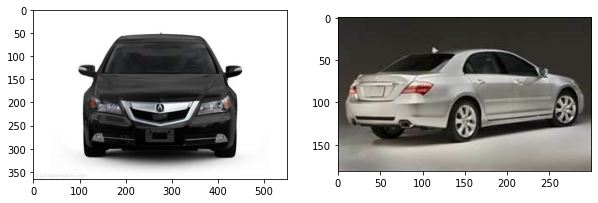

PREDICTION:Chrysler PT Cruiser Convertible 2008, ACTUAL:Mitsubishi Lancer Sedan 2012
Loss: 6.41, Probability: 1.9355


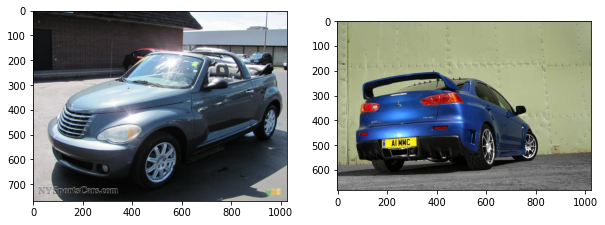

PREDICTION:Acura TSX Sedan 2012, ACTUAL:Acura ZDX Hatchback 2012
Loss: 5.98, Probability: -2.2168


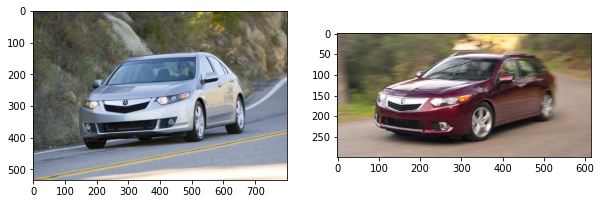

PREDICTION:Rolls-Royce Phantom Sedan 2012, ACTUAL:Rolls-Royce Ghost Sedan 2012
Loss: 5.86, Probability: -0.1736


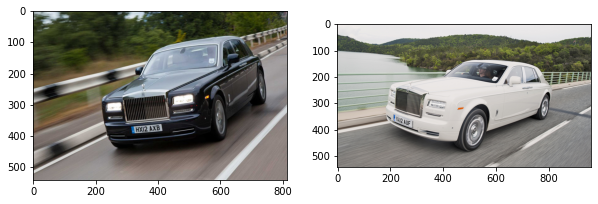

PREDICTION:AM General Hummer SUV 2000, ACTUAL:Ford F-450 Super Duty Crew Cab 2012
Loss: 5.70, Probability: 0.1246


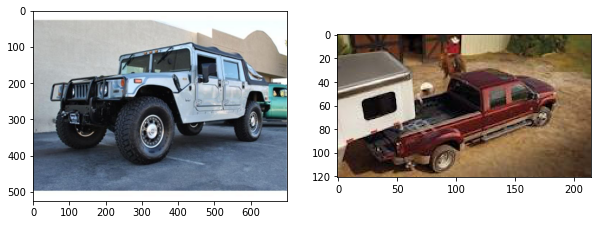

PREDICTION:Audi TTS Coupe 2012, ACTUAL:Audi TT Hatchback 2011
Loss: 5.51, Probability: 2.2676


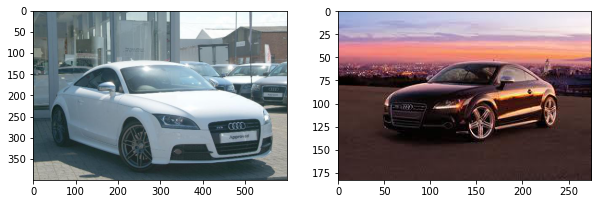

PREDICTION:BMW 3 Series Sedan 2012, ACTUAL:BMW M5 Sedan 2010
Loss: 5.50, Probability: 0.4126


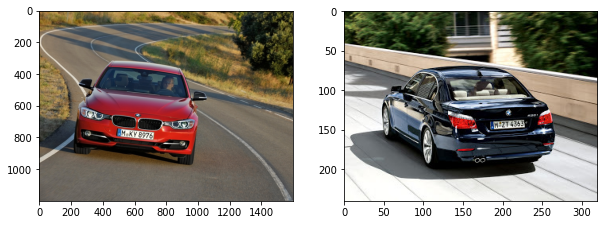

PREDICTION:Fisker Karma Sedan 2012, ACTUAL:Ferrari 458 Italia Coupe 2012
Loss: 5.40, Probability: 0.2996


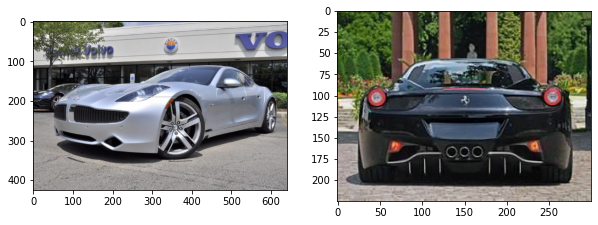

PREDICTION:Scion xD Hatchback 2012, ACTUAL:Nissan Juke Hatchback 2012
Loss: 5.38, Probability: -0.7446


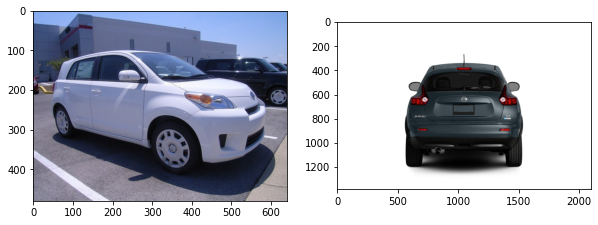

PREDICTION:McLaren MP4-12C Coupe 2012, ACTUAL:Lamborghini Gallardo LP 570-4 Superleggera 2012
Loss: 5.32, Probability: 0.0666


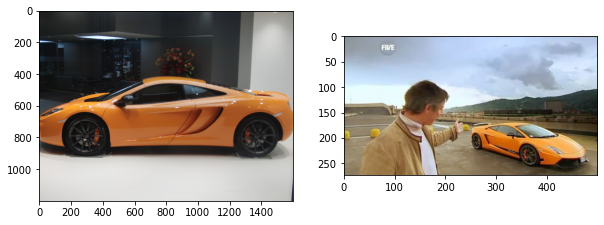

In [22]:
compare_top_losses(10, interp, labels_df, 1, path=path)

# Testiranje na testnom setu podataka

Predikcija na samo jednoj slici iz testnog seta

In [23]:
test_labels_df.head()

,filename,class_name,class_id,vocab_id
0,test_00001.jpg,Suzuki Aerio Sedan 2007,181,180
1,test_00002.jpg,Ferrari 458 Italia Convertible 2012,103,100
2,test_00003.jpg,Jeep Patriot SUV 2012,145,147
3,test_00004.jpg,Toyota Camry Sedan 2012,187,186
4,test_00005.jpg,Tesla Model S Sedan 2012,185,184


In [24]:
test_item = path/'merged'/test_labels_df['filename'][0]; test_item

Path('C:/Users/Morningstar/Documents/CARSv2/merged/test_00001.jpg')

In [25]:
pred_y,pred_idx,probs=learn.predict(test_item)

In [26]:
act_y_id = test_labels_df['vocab_id'][0]
act_y = test_labels_df['class_name'][0]

In [27]:
np.argmax(probs)

tensor(180)

In [28]:
pred_y,act_y

("['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura Integra Type R 2001', 'AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura Integra Type R 2001', 'AM General Hummer SUV 2000', 'smart fortwo Convertible 2012', 'AM General Hummer SUV 2000', 'smart fortwo Convertible 2012', 'smart fortwo Convertible 2012', 'Acura RL Sedan 2012', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'smart fortwo Convertible 2012', 'AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'AM General Hummer SUV 2000', 'smart fortwo Convertible 2012', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura RL Sedan 2012', 'AM General Hummer SUV 2000', 'A

In [29]:
np.argmax(pred_idx),act_y_id

(tensor(180), 180)

Ucitavanje testnih itema na isti nacin kao sto smo ucitavali trening iteme kroz get_x funkciju

In [28]:
test_items = get_x(test_labels_df);test_items

0       C:\Users\Morningstar\Documents\CARSv2\merged\test_00001.jpg
1       C:\Users\Morningstar\Documents\CARSv2\merged\test_00002.jpg
2       C:\Users\Morningstar\Documents\CARSv2\merged\test_00003.jpg
3       C:\Users\Morningstar\Documents\CARSv2\merged\test_00004.jpg
4       C:\Users\Morningstar\Documents\CARSv2\merged\test_00005.jpg
                                   ...                             
8036    C:\Users\Morningstar\Documents\CARSv2\merged\test_08037.jpg
8037    C:\Users\Morningstar\Documents\CARSv2\merged\test_08038.jpg
8038    C:\Users\Morningstar\Documents\CARSv2\merged\test_08039.jpg
8039    C:\Users\Morningstar\Documents\CARSv2\merged\test_08040.jpg
8040    C:\Users\Morningstar\Documents\CARSv2\merged\test_08041.jpg
Name: filename, Length: 8041, dtype: object

Kreiranje test dataloader objekta koji ce sadrzavati sve test iteme

In [29]:
test_dl = learn.dls.test_dl(test_items)

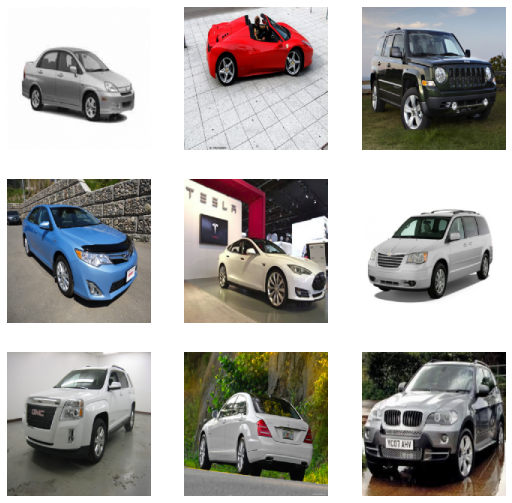

In [19]:
test_dl.show_batch()

Predikcije nad citavim test setom

In [30]:
preds = learn.get_preds(dl=test_dl)

Da bi provjerili tacnost na citavom datasetu prvo trebamo spasiti sve predikcije u jednu varijablu.

Mozemo primjetiti oblik tensora za predikcije, koji je broj slika (8041) sa broj klasa (196), jer za svaku sliku sadrzava 196 vrijednosti koje izgledaju isto kao sto smo vidjeli iznad.

In [31]:
a = preds[0]; a.shape

torch.Size([8041, 196])

Zatim nam treba varijabla, tj tensor s kojim cemo porediti ove predikcije, odnosno onaj koji sadrzava stvarne vrijednosti klasa za slike iz test seta.

Za te potrebe kreirat cemo numpy array koji cemo poslije pretvoriti u PyTorch tensor.

In [32]:
b = np.array(test_labels_df['vocab_id'],dtype=np.int)
b = torch.from_numpy(b);b.shape

torch.Size([8041])

In [22]:
b[0]

tensor(180, dtype=torch.int32)

Sve sto nam preostaje je da pozovemo accuracy funkciju koja ce za nas na proslijedenom tensoru a uraditi argmax funkciju i porediti sa proslijedenim tensorom b

In [33]:
accuracy(a,b)

tensor(0.9083)

Tacnost je 91.16% sto je do sada najbolji rezultat. To je i jednim dijelom rezultat koristenja druge naprednije arhitekture i kombinacije metoda treniranja sa drugim optimizatorom i aktivacijskom funkcijom.

Jedna stvar koja je bitna za primjetiti je da je validacijski gubitak (val. loss) manji od trening gubitka (train. loss), sto je direktan rezultat regularizacije koja je sprijecila model da overfittuje na trening set.

In [34]:
learn.export(fname='test_model.pkl')